In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
import random
from scipy.stats import linregress
import warnings

warnings.filterwarnings('ignore')
from scipy.ndimage import label
import powerlaw
import numpy as np

np.seterr(invalid="ignore", divide="ignore", over="ignore", under="ignore")   # also: divide="ignore", over="ignore", under="ignore"
import warnings
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message=r"invalid value encountered in add"
)

from scipy.special import zeta  # For normalization
from scipy.ndimage import label
from scipy.ndimage import find_objects
from scipy.ndimage import label
import powerlaw
warnings.filterwarnings('ignore')
import cma

In [2]:
def fit_power_law_numpy(data):
    """
    Fits a power-law distribution to discrete data using the Clauset, Shalizi, Newman method.

    Returns a dictionary containing fit parameters and data for plotting.
    """
    # --- The first part of the function (finding the best alpha and xmin) is the same ---
    possible_xmins = np.unique(data)
    possible_xmins = possible_xmins[possible_xmins < np.max(possible_xmins)]

    if len(possible_xmins) < 2:
        return {'alpha': 1.0, 'xmin': 1, 'ks_distance': 1.0, 'fit_successful': False}

    ks_distances = []
    alphas = []

    for xmin_candidate in possible_xmins:
        tail_data = data[data >= xmin_candidate]
        n_tail = len(tail_data)
        if n_tail < 10:
            ks_distances.append(np.inf)
            alphas.append(1.0)
            continue

        alpha_mle = 1.0 + n_tail / np.sum(np.log(tail_data / (xmin_candidate - 0.5)))
        alphas.append(alpha_mle)

        empirical_cdf = np.arange(1, n_tail + 1) / n_tail
        unique_tail_data, counts = np.unique(tail_data, return_counts=True)

        # This part has been simplified for clarity, the logic is the same
        theoretical_cdf = np.cumsum((unique_tail_data**-alpha_mle) / zeta(alpha_mle, xmin_candidate))
        cdf_map = dict(zip(unique_tail_data, theoretical_cdf))
        theoretical_cdf_full = np.array([cdf_map[val] for val in tail_data])

        ks_distance = np.max(np.abs(empirical_cdf - theoretical_cdf_full))
        ks_distances.append(ks_distance)

    if np.all(np.isinf(ks_distances)):
        return {'alpha': 1.0, 'xmin': 1, 'ks_distance': 1.0, 'fit_successful': False}

    best_idx = np.argmin(ks_distances)
    best_xmin = possible_xmins[best_idx]
    best_alpha = alphas[best_idx]
    min_ks_distance = ks_distances[best_idx]

    # --- NEW: Calculate data for plotting ---

    # 1. Empirical PDF (Probability Density Function)
    unique_sizes, counts = np.unique(data, return_counts=True)
    empirical_pdf_y = counts / len(data)
    empirical_pdf_x = unique_sizes

    # 2. Theoretical PDF (the fitted line)
    # The line should only be drawn for x >= xmin
    fit_pdf_x = np.arange(best_xmin, np.max(data) + 1, dtype=np.float64)
    # Normalization constant C = 1 / zeta(alpha, xmin)
    normalization_const = 1 / zeta(best_alpha, best_xmin)
    fit_pdf_y = normalization_const * (fit_pdf_x ** -best_alpha)

    # 3. Package everything into a dictionary
    results = {
        'alpha': best_alpha,
        'xmin': best_xmin,
        'ks_distance': min_ks_distance,
        'fit_successful': True,
        'empirical_pdf_x': empirical_pdf_x,
        'empirical_pdf_y': empirical_pdf_y,
        'fit_pdf_x': fit_pdf_x,
        'fit_pdf_y': fit_pdf_y
    }

    return results

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from skimage import measure
import powerlaw

# -------------------------
# Helpers copied from paper
# -------------------------
def KSdist(theoretical_pdf, empirical_pdf):
    theoretical_pdf = np.asarray(theoretical_pdf, dtype=np.float64)
    empirical_pdf   = np.asarray(empirical_pdf,   dtype=np.float64)
    if theoretical_pdf.sum() > 0:
        theoretical_pdf = theoretical_pdf / theoretical_pdf.sum()
    if empirical_pdf.sum() > 0:
        empirical_pdf   = empirical_pdf / empirical_pdf.sum()
    return float(np.max(np.abs(np.cumsum(theoretical_pdf) - np.cumsum(empirical_pdf))))

def getdict_cluster_size(arr1d):
    cluster_dict = {}
    current_number = None
    for a in arr1d:
        if current_number == a:
            cluster_dict[a][-1] = cluster_dict[a][-1] + 1
        else:
            current_number = a
            if a in cluster_dict:
                cluster_dict[a].append(1)
            else:
                cluster_dict[a] = [1]
    return cluster_dict

def getarray_avalanche_size(x, value):
    list_avalance_size = []
    if value in x:
        x0size, x1size = x.shape
        for i in range(x0size):
            if value in x[i, :]:
                list_avalance_size.extend(getdict_cluster_size(x[i, :])[value])
    return np.array(list_avalance_size)

def getarray_avalanche_duration(x, value):
    list_avalance_duration = []
    if value in x:
        x0size, x1size = x.shape
        for i in range(x1size):
            if value in x[:, i]:
                list_avalance_duration.extend(getdict_cluster_size(x[:, i])[value])
    return np.array(list_avalance_duration)

def norm_ksdist(ksdist, smooth=1):
    # exp(- α_D * (0.9*min(mean of first 3, mean of last 3) + 0.1*overall mean))
    return float(np.exp(-smooth * (0.9 * min(np.mean(ksdist[:3]), np.mean(ksdist[3:])) + 0.1 * np.mean(ksdist))))

def norm_linscore(linscore):
    return float(np.mean(linscore))

def norm_coef(coef):
    return float(-np.mean(coef))

def sigmoid(x, smooth=0.01):
    return float(1. / (1. + np.exp(-x * smooth)))

def norm_R(R_list):
    return sigmoid(0.9 * max(np.mean(R_list[:3]), np.mean(R_list[3:])) + 0.1 * np.mean(R_list), smooth=0.01)

def normalize_avalanche_pdf_size(mask_avalanche_s_0_bc, mask_avalanche_d_0_bc,
                                 mask_avalanche_t_0_bc, mask_avalanche_s_1_bc,
                                 mask_avalanche_d_1_bc, mask_avalanche_t_1_bc,
                                 width, timesteps):
    norm_avalanche_pdf_size_s_0 = np.sum(mask_avalanche_s_0_bc) / width
    norm_avalanche_pdf_size_d_0 = np.sum(mask_avalanche_d_0_bc) / timesteps
    norm_avalanche_pdf_size_t_0 = np.sum(mask_avalanche_t_0_bc) / (timesteps * width)
    norm_avalanche_pdf_size_s_1 = np.sum(mask_avalanche_s_1_bc) / width
    norm_avalanche_pdf_size_d_1 = np.sum(mask_avalanche_d_1_bc) / timesteps
    norm_avalanche_pdf_size_t_1 = np.sum(mask_avalanche_t_1_bc) / (timesteps * width)

    mean_avalanche_pdf_size = np.mean([
        norm_avalanche_pdf_size_s_0, norm_avalanche_pdf_size_d_0, norm_avalanche_pdf_size_t_0,
        norm_avalanche_pdf_size_s_1, norm_avalanche_pdf_size_d_1, norm_avalanche_pdf_size_t_1
    ])

    max_avalanche_pdf_size = max(
        np.mean([norm_avalanche_pdf_size_s_0, norm_avalanche_pdf_size_d_0, norm_avalanche_pdf_size_t_0]),
        np.mean([norm_avalanche_pdf_size_s_1, norm_avalanche_pdf_size_d_1, norm_avalanche_pdf_size_t_1])
    )

    return float(np.tanh(5 * (0.9 * max_avalanche_pdf_size + 0.1 * mean_avalanche_pdf_size)))

def calculate_comparison_ratio(data):
    fit = powerlaw.Fit(data, xmin=1, discrete=True)
    R_exp, p_exp = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    return float(R_exp if p_exp < 0.1 else 0.0)

# -------------------------
# Labeling exactly as paper
# -------------------------
def get_numbered_avalanches(x, value):
    x_value = (x == value).astype(np.int8)
    numbered_avalanches_x = measure.label(x_value, background=0)
    # Merge wrap-around labels touching both sides
    for i in range(numbered_avalanches_x.shape[0]):
        if (numbered_avalanches_x[i, 0] != 0 and
            numbered_avalanches_x[i, -1] != 0 and
            numbered_avalanches_x[i, 0] != numbered_avalanches_x[i, -1]):
            numbered_avalanches_x[numbered_avalanches_x == numbered_avalanches_x[i, -1]] = numbered_avalanches_x[i, 0]
    return numbered_avalanches_x

def getarray_avalanche_size_duration_total(x, value):
    numbered_avalanches = get_numbered_avalanches(x, value)
    number_of_avalanches = int(np.max(numbered_avalanches))
    avalanche_size, avalanche_duration, avalanche_total = [], [], []
    for avalanche_number in range(1, number_of_avalanches + 1):
        avalanche = np.argwhere(numbered_avalanches == avalanche_number)
        if len(avalanche) > 0:
            avalanche_duration.append(len(np.unique(avalanche[:, 0])))
            avalanche_size.append(len(np.unique(avalanche[:, 1])))
            avalanche_total.append(len(avalanche))
    return avalanche_size, avalanche_duration, avalanche_total

# --------------------------------------
# Literal port of evaluate_result(...) —
# — but parameterized by width/timesteps
# --------------------------------------
def evaluate_result_port(ca_result_bin):
    """
    ca_result_bin: 2D uint8/bool array (timesteps x width) with values {0,1}
    Returns: fitness (positive), val_dict (same fields as paper)
    """
    timesteps, width = ca_result_bin.shape

    # Collect avalanches for both states and all three measures
    avalanche_s_0, avalanche_d_0, avalanche_t_0 = getarray_avalanche_size_duration_total(ca_result_bin, 0)
    avalanche_s_1, avalanche_d_1, avalanche_t_1 = getarray_avalanche_size_duration_total(ca_result_bin, 1)

    # Bin counts, drop zero bin, require >5 samples as in paper paths
    avalanche_s_0_bc = np.bincount(avalanche_s_0)[1:] if len(avalanche_s_0) > 5 else np.array([])
    avalanche_d_0_bc = np.bincount(avalanche_d_0)[1:] if len(avalanche_d_0) > 5 else np.array([])
    avalanche_t_0_bc = np.bincount(avalanche_t_0)[1:] if len(avalanche_t_0) > 5 else np.array([])

    avalanche_s_1_bc = np.bincount(avalanche_s_1)[1:] if len(avalanche_s_1) > 5 else np.array([])
    avalanche_d_1_bc = np.bincount(avalanche_d_1)[1:] if len(avalanche_d_1) > 5 else np.array([])
    avalanche_t_1_bc = np.bincount(avalanche_t_1)[1:] if len(avalanche_t_1) > 5 else np.array([])

    # Normalize to PDFs (paper does this)
    def _to_pdf(bc):
        bc = np.asarray(bc, dtype=np.float64)
        s = bc.sum()
        return bc / s if s > 0 else bc

    avalanche_s_0_bc = _to_pdf(avalanche_s_0_bc)
    avalanche_d_0_bc = _to_pdf(avalanche_d_0_bc)
    avalanche_t_0_bc = _to_pdf(avalanche_t_0_bc)
    avalanche_s_1_bc = _to_pdf(avalanche_s_1_bc)
    avalanche_d_1_bc = _to_pdf(avalanche_d_1_bc)
    avalanche_t_1_bc = _to_pdf(avalanche_t_1_bc)

    # Masks for non-zero bins (paper uses these)
    mask_avalanche_s_0_bc = avalanche_s_0_bc > 0
    mask_avalanche_d_0_bc = avalanche_d_0_bc > 0
    mask_avalanche_t_0_bc = avalanche_t_0_bc > 0
    mask_avalanche_s_1_bc = avalanche_s_1_bc > 0
    mask_avalanche_d_1_bc = avalanche_d_1_bc > 0
    mask_avalanche_t_1_bc = avalanche_t_1_bc > 0

    # log10 PDFs, zeros where masked out (exactly like the paper)
    def _log_masked(pdf, mask):
        logp = np.zeros_like(pdf)
        nz = mask
        logp[nz] = np.log10(pdf[nz])
        return logp

    log_avalanche_s_0_bc = _log_masked(avalanche_s_0_bc, mask_avalanche_s_0_bc)
    log_avalanche_d_0_bc = _log_masked(avalanche_d_0_bc, mask_avalanche_d_0_bc)
    log_avalanche_t_0_bc = _log_masked(avalanche_t_0_bc, mask_avalanche_t_0_bc)
    log_avalanche_s_1_bc = _log_masked(avalanche_s_1_bc, mask_avalanche_s_1_bc)
    log_avalanche_d_1_bc = _log_masked(avalanche_d_1_bc, mask_avalanche_d_1_bc)
    log_avalanche_t_1_bc = _log_masked(avalanche_t_1_bc, mask_avalanche_t_1_bc)

    # --- Hard gate: need >5 non-zero bins among first 10, for all six dists ---
    def _left10_nonzero(mask):
        return int(np.sum(mask[:10]))

    if not ( _left10_nonzero(mask_avalanche_s_0_bc) > 5 and
             _left10_nonzero(mask_avalanche_d_0_bc) > 5 and
             _left10_nonzero(mask_avalanche_t_0_bc) > 5 and
             _left10_nonzero(mask_avalanche_s_1_bc) > 5 and
             _left10_nonzero(mask_avalanche_d_1_bc) > 5 and
             _left10_nonzero(mask_avalanche_t_1_bc) > 5 ):
        # Paper returns effectively zero fitness if this fails
        return 0.0, {
            "norm_ksdist_res": 0.0,
            "norm_coef_res":   0.0,
            "norm_unique_states": 0.0,
            "norm_avalanche_pdf_size": 0.0,
            "norm_linscore_res": 0.0,
            "norm_R_res": 0.0,
            "fitness": 0.0,
        }

    # --- Fit log–log lines (unweighted R^2), then refit with sample_weight for first 10 bins ---
    def _fit_lin(pdf, log_pdf, mask):
        xs = np.log10(np.arange(1, len(pdf) + 1)[mask]).reshape(-1, 1)
        ys = log_pdf[mask]
        if xs.shape[0] == 0:
            return None, 0.0
        lr = LinearRegression().fit(xs, ys)
        r2 = lr.score(xs, ys)
        # re-fit with weights that are 1 for bins <10, else 0 (paper’s weighted fit)
        idxs_all = np.arange(len(pdf))[mask]
        w = np.array([1 if idx < 10 else 0 for idx in idxs_all], dtype=float)
        lr_w = LinearRegression().fit(xs, ys, sample_weight=w)
        return (lr, lr_w)

    fits = []
    for pdf, logp, mask in [
        (avalanche_s_0_bc, log_avalanche_s_0_bc, mask_avalanche_s_0_bc),
        (avalanche_d_0_bc, log_avalanche_d_0_bc, mask_avalanche_d_0_bc),
        (avalanche_t_0_bc, log_avalanche_t_0_bc, mask_avalanche_t_0_bc),
        (avalanche_s_1_bc, log_avalanche_s_1_bc, mask_avalanche_s_1_bc),
        (avalanche_d_1_bc, log_avalanche_d_1_bc, mask_avalanche_d_1_bc),
        (avalanche_t_1_bc, log_avalanche_t_1_bc, mask_avalanche_t_1_bc),
    ]:
        lr, lr_w = _fit_lin(pdf, logp, mask)
        fits.append((pdf, logp, mask, lr, lr_w))

    # R^2 list from the unweighted fits
    linscore_list = []
    for pdf, logp, mask, lr, lr_w in fits:
        xs = np.log10(np.arange(1, len(pdf) + 1)[mask]).reshape(-1, 1)
        ys = logp[mask]
        linscore_list.append(lr.score(xs, ys))

    # Theoretical PDFs from the weighted fits (full support, not only masked bins)
    def _theor_from_fit(lr_w, L):
        xs_full = np.log10(np.arange(1, L + 1).reshape(-1, 1))
        pred = lr_w.predict(xs_full)  # log10(pdf)
        theor = np.power(10.0, pred)
        return theor

    theor_avalanche_s_0_bc = _theor_from_fit(fits[0][4], len(avalanche_s_0_bc))
    theor_avalanche_d_0_bc = _theor_from_fit(fits[1][4], len(avalanche_d_0_bc))
    theor_avalanche_t_0_bc = _theor_from_fit(fits[2][4], len(avalanche_t_0_bc))
    theor_avalanche_s_1_bc = _theor_from_fit(fits[3][4], len(avalanche_s_1_bc))
    theor_avalanche_d_1_bc = _theor_from_fit(fits[4][4], len(avalanche_d_1_bc))
    theor_avalanche_t_1_bc = _theor_from_fit(fits[5][4], len(avalanche_t_1_bc))

    # KS against the fitted curves
    ksdist_list = [
        KSdist(theor_avalanche_s_0_bc, avalanche_s_0_bc),
        KSdist(theor_avalanche_d_0_bc, avalanche_d_0_bc),
        KSdist(theor_avalanche_t_0_bc, avalanche_t_0_bc),
        KSdist(theor_avalanche_s_1_bc, avalanche_s_1_bc),
        KSdist(theor_avalanche_d_1_bc, avalanche_d_1_bc),
        KSdist(theor_avalanche_t_1_bc, avalanche_t_1_bc),
    ]

    # Coefs (slopes) from the weighted fits
    coef_list = [
        fits[0][4].coef_[0], fits[1][4].coef_[0], fits[2][4].coef_[0],
        fits[3][4].coef_[0], fits[4][4].coef_[0], fits[5][4].coef_[0],
    ]

    # B (coverage of first-10 bins), exactly as in paper's normalize function
    norm_avalanche_pdf_size = normalize_avalanche_pdf_size(
        fits[0][2], fits[1][2], fits[2][2], fits[3][2], fits[4][2], fits[5][2],
        width=width, timesteps=timesteps
    )

    # Map components to [0,1] in the same way
    norm_linscore_res   = norm_linscore(linscore_list)
    norm_ksdist_res     = norm_ksdist(ksdist_list)
    norm_coef_res       = norm_coef(coef_list)
    norm_unique_states  = (np.unique(ca_result_bin, axis=0).shape[0]) / float(width)

    # Final fitness (positive)
    fitness = (norm_ksdist_res ** 2) + norm_unique_states + norm_avalanche_pdf_size + (norm_linscore_res ** 2)

    # Optional L̂ term (power law vs exponential); only if fitness > 3.0, like the paper
    norm_R_res = 0.0
    if fitness > 3.0:
        R_list = [
            calculate_comparison_ratio(getarray_avalanche_size(ca_result_bin, 0)),
            calculate_comparison_ratio(getarray_avalanche_duration(ca_result_bin, 0)),
            calculate_comparison_ratio(getarray_avalanche_size_duration_total(ca_result_bin, 0)[2]),
            calculate_comparison_ratio(getarray_avalanche_size(ca_result_bin, 1)),
            calculate_comparison_ratio(getarray_avalanche_duration(ca_result_bin, 1)),
            calculate_comparison_ratio(getarray_avalanche_size_duration_total(ca_result_bin, 1)[2]),
        ]
        norm_R_res = norm_R(R_list)
        fitness += norm_R_res

    val_dict = {
        "norm_ksdist_res":      float(norm_ksdist_res),
        "norm_coef_res":        float(norm_coef_res),
        "norm_unique_states":   float(norm_unique_states),
        "norm_avalanche_pdf_size": float(norm_avalanche_pdf_size),
        "norm_linscore_res":    float(norm_linscore_res),
        "norm_R_res":           float(norm_R_res),
        "fitness":              float(fitness),
    }
    return float(fitness), val_dict

# --------------------------------------
# Public entry-point for your CEM
# --------------------------------------



In [4]:
def _get_avalanches(matrix, state):
    """
    [Corrected Version - Reflects Figure 1's definitions]
    Finds all spatiotemporal avalanches and calculates their size, duration, and area
    according to the specific definitions in the Pontes-Filho et al. paper.

    - size: Number of unique spatial cells (columns) affected.
    - duration: Number of time-steps the avalanche lasts.
    - area: Total number of spatiotemporal cells in the cluster.

    Args:
        matrix (np.ndarray): The binarized (T, N) state matrix.
        state (int): The state to search for (0 or 1).

    Returns:
        tuple: A tuple containing three lists: (sizes, durations, areas).
    """
    T, N = matrix.shape
    state_matrix = (matrix == state)

    structure = np.ones((3, 3), dtype=int)
    labeled_matrix, num_avalanches = label(state_matrix, structure=structure)

    if num_avalanches == 0:
        return [], [], []

    # --- Area Calculation (total cells in cluster) ---
    # This part was already correct.
    # np.bincount is the most efficient way to get the size of each labeled region.
    # We discard the count for label 0, which is the background.
    areas = np.bincount(labeled_matrix.ravel())[1:]

    # --- Duration Calculation (temporal extent) ---
    # This part was also correct.
    # find_objects gives us the bounding box for each labeled avalanche.
    locations = find_objects(labeled_matrix)
    durations = [loc[0].stop - loc[0].start for loc in locations]

    # --- Size Calculation (unique spatial cells affected) ---
    # This is the new, corrected logic.

    # Create an array where each element is its own column index.
    # e.g., for N=4, it's [[0,1,2,3], [0,1,2,3], ...]
    cols_grid = np.tile(np.arange(N), (T, 1))

    # Flatten both the labels and the column indices.
    labels_flat = labeled_matrix.ravel()
    cols_flat = cols_grid.ravel()

    # We only care about cells that are part of an avalanche (label > 0).
    mask = labels_flat > 0
    active_labels = labels_flat[mask]
    active_cols = cols_flat[mask]

    # Create a 2D array of [label, column] pairs.
    label_col_pairs = np.stack([active_labels, active_cols], axis=1)

    # Find the unique pairs. This is the key step.
    # For each avalanche, this effectively lists each column it touches exactly once.
    unique_label_col_pairs = np.unique(label_col_pairs, axis=0)

    # Now, count how many unique columns belong to each label.
    # The first column of unique_label_col_pairs contains the labels.
    # By counting the occurrences of each label ID, we get the 'size'.
    unique_labels, sizes = np.unique(unique_label_col_pairs[:, 0], return_counts=True)

    # We need to ensure the sizes array is correctly ordered and sized in case some
    # label IDs were skipped (though this is unlikely with np.unique).
    # We create a zero-filled array and place the counts at the correct index.
    final_sizes = np.zeros(num_avalanches, dtype=int)
    # unique_labels are 1-based, so we subtract 1 for 0-based indexing.
    final_sizes[unique_labels.astype(int) - 1] = sizes

    return final_sizes.tolist(), durations, areas.tolist()
def _calculate_metrics_from_dist(distribution, num_bins=10):
    """
    [Corrected Version 4]
    Calculates R^2 and alpha by fitting a line to the log-log plot of the
    PROBABILITY DENSITY, which correctly handles logarithmic binning.
    This will produce the correct positive alpha.
    """
    total_avalanches = len(distribution)
    results = {
        'R2': 0.0, 'B': 0.0, 'alpha': 0.0,
        'empirical_x': None, 'empirical_y': None,
        'fit_x': None, 'fit_y': None
    }

    if total_avalanches < 20:
        return results

    # 1. Empirical PDF for plotting the scattered blue data.
    # We will plot density here as well for consistency.
    unique_vals, counts = np.unique(distribution, return_counts=True)
    # This is a PMF (Probability Mass Function), not a density, but is standard for scatter plots.
    probabilities = counts / total_avalanches
    results['empirical_x'] = unique_vals
    results['empirical_y'] = probabilities

    # 2. Binned data for regression
    min_val, max_val = np.min(distribution), np.max(distribution)
    if min_val <= 0 or min_val == max_val:
        return results # log scale requires positive values

    bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
    hist_counts, bin_edges = np.histogram(distribution, bins=bins)

    # --- CRITICAL FIX: Calculate Probability Density ---

    # Calculate the width of each bin
    bin_widths = np.diff(bin_edges)

    # Calculate density, avoiding division by zero
    with warnings.catch_warnings(): # Suppress 'invalid value encountered in true_divide'
        warnings.simplefilter("ignore", RuntimeWarning)
        densities = hist_counts / (total_avalanches * bin_widths)

    # --- Perform Regression on Density ---
    non_zero_mask = densities > 0
    densities_for_fit = densities[non_zero_mask]

    if len(densities_for_fit) < 3:
        return results

    bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)[non_zero_mask]

    log_x = np.log10(bin_centers)
    log_y = np.log10(densities_for_fit)

    slope, intercept, r_value, _, _ = linregress(log_x, log_y)

    # 3. Store the calculated metrics
    results['R2'] = r_value**2 if np.isfinite(r_value) else 0.0
    results['B'] = np.sum(hist_counts > 0) / num_bins
    # The slope of the density plot is -alpha, so alpha = -slope
    results['alpha'] = -slope

    # 4. Generate the fitted line for plotting
    fit_x_coords = bin_centers

    # The line is y = 10^(m*log10(x) + c) in density space
    predicted_log_y_density = slope * np.log10(fit_x_coords) + intercept
    predicted_y_density = 10**predicted_log_y_density

    results['fit_x'] = fit_x_coords

    # The y-values of the fit line are densities. We need to convert them to
    # probabilities to match the y-axis of the empirical plot (P(x)).
    # Prob ~ Density * BinWidth. We use the average bin width for simplicity.
    avg_bin_width = np.mean(bin_widths)
    results['fit_y'] = predicted_y_density * avg_bin_width * 10 # Heuristic scaling factor for better visualization

    # A better approach for the fit line is to plot it in density space, and the empirical data too.
    # Let's adjust the empirical data for a more direct comparison.
    results['empirical_y'] = probabilities # Keep as PMF for clarity
    results['fit_y'] = 10**(slope * np.log10(results['empirical_x']) + intercept) * avg_bin_width # Re-evaluate on empirical x

    return results


def crit_binarize_copy(A, thresh=0.0):
    # Hard copy so nothing downstream can alias the caller's buffer
    Af = np.array(A, dtype=float, copy=True)
    Af = np.nan_to_num(Af, nan=0.0, posinf=0.0, neginf=0.0)
    return (Af > thresh).astype(np.uint8, copy=False)  # internal, never returned

def _label_components_8c(mask):
    # Strictly read-only w.r.t. input
    try:
        from scipy.ndimage import label
        structure = np.ones((3,3), dtype=np.uint8)
        labels, nlab = label(mask, structure=structure)
        return labels.astype(np.int32, copy=False), int(nlab)
    except Exception:
        H, W = mask.shape
        labels = np.zeros_like(mask, dtype=np.int32)
        nlab = 0
        nbrs = [(di,dj) for di in (-1,0,1) for dj in (-1,0,1) if (di or dj)]
        for i in range(H):
            js = np.where(mask[i] & (labels[i]==0))[0]
            for j in js:
                if labels[i,j] != 0: continue
                nlab += 1
                stack = [(i,j)]
                labels[i,j] = nlab
                while stack:
                    ti,tj = stack.pop()
                    for di,dj in nbrs:
                        ui = ti + di
                        uj = (tj + dj) % W  # periodic in space, no wrap in time
                        if ui < 0 or ui >= H: continue
                        if mask[ui,uj] and labels[ui,uj]==0:
                            labels[ui,uj] = nlab
                            stack.append((ui,uj))
        return labels, nlab

def _per_label_area(lbl_img, num_labels):
    if num_labels == 0: return np.zeros(0, np.int64)
    bc = np.bincount(lbl_img.ravel(), minlength=num_labels+1)
    return bc[1:].astype(np.int64)

def _per_label_unique(lbls, coords):
    if lbls.size == 0: return np.zeros(0, np.int64)
    pairs = np.stack([lbls, coords], axis=1)
    uniq = np.unique(pairs, axis=0)
    return np.bincount(uniq[:,0], minlength=int(uniq[:,0].max())+1)[1:]

def _first10_hist(values):
    if len(values)==0:
        counts = np.zeros(10, np.int64)
    else:
        v = np.asarray(values, np.int64)
        v = v[v>=1]
        v = np.minimum(v, 10)            # clip ≥10 into bin 10
        counts = np.bincount(v, minlength=11)[1:11]
    nonzero = (counts>0).sum()
    Bpct = nonzero/10.0
    return counts.astype(np.float64), Bpct

def _fit_ls_R2_KS(counts10):
    k = np.arange(1,11, dtype=np.float64)
    y = counts10.astype(np.float64)
    nz = y>0
    if nz.sum() <= 1:
        return 0.0, 1.0
    p = y[nz] / y[nz].sum()
    x = np.log10(k[nz])
    t = np.log10(p)
    A = np.vstack([x, np.ones_like(x)]).T
    b, a = np.linalg.lstsq(A, t, rcond=None)[0]  # log10 p ≈ a + b log10 k
    t_hat = a + b*x
    ss_res = np.sum((t - t_hat)**2)
    ss_tot = np.sum((t - t.mean())**2)
    R2 = 1.0 - (ss_res/ss_tot if ss_tot>0 else 1.0)
    alpha = -b
    w = (k[nz] ** (-alpha))
    w /= w.sum()
    D = float(np.max(np.abs(np.cumsum(p) - np.cumsum(w))))
    return float(np.clip(R2, -1.0, 1.0)), float(np.clip(D, 0.0, 1.0))

def _aggregate_scores(R2s, Ds, Bs, U):
    # Eqns (2)-(7) with the paper’s α; we map small KS→high score with a minus sign in exp
    aR2, aD, aB, aL = 0.01, 1.0, 5.0, 0.01

    R2s = np.asarray(R2s); Ds = np.asarray(Ds); Bs = np.asarray(Bs)
    R2_0, R2_1, R2_all = R2s[:3].mean(), R2s[3:].mean(), R2s.mean()
    D_0,  D_1,  D_all  = Ds[:3].mean(),  Ds[3:].mean(),  Ds.mean()
    B_0,  B_1,  B_all  = Bs[:3].mean(),  Bs[3:].mean(),  Bs.mean()

    sig = lambda z: 1.0/(1.0+np.exp(-z))
    Rhat = sig(aR2*(0.9*max(R2_0,R2_1)+0.1*R2_all))                       # (2)
    Dhat = float(np.exp(-aD*(0.9*min(D_0,D_1)+0.1*D_all)))                # (3) mapped so smaller KS→larger score
    Bhat = float(np.tanh(aB*(0.9*max(B_0,B_1)+0.1*B_all)))                # (4)

    Spartial = (Rhat**2) + (Dhat**2) + Bhat + float(U)                    # (6)
    return float(Spartial)                                                # (7) w/o L̂ for speed/robustness




In [5]:
class CEM1Layer:

    def __init__(self, N, T, dt, alpha_m,
                 theta=None, gamma=0.0, rng_seed=42, init_scale=1.0):
        self.N = int(N)
        self.T = int(T)
        self.dt = float(dt)
        self.alpha_m = float(alpha_m)   # kept for interface compatibility
        self.gamma = float(gamma)



        if theta is None:
            self.theta = {
                "k0": random.uniform(-0.10,  0.10),
                "k1": random.uniform(-0.40,  0.40),
                "k2": random.uniform(-0.60,  0.60),
                "k3": random.uniform(-0.40,  0.40),
                "k4": random.uniform(-0.30,  0.30),
                "k5": random.uniform(-0.30,  0.30),
                "k6": random.uniform(-0.15,  0.15),
            }
        else:
            keys = ["k0","k1","k2","k3","k4","k5","k6"]
            self.theta = {k: float(theta.get(k, 0.0)) for k in keys}

        # Allocate state history buffers to mirror your class
        self.A = np.empty((self.T + 1, self.N), dtype=float)


        # Fitness bookkeeping (mirrors your attributes)
        self.fitness = -1e3
        self.fit_res = None

        # Initialize state (A[0]) like your __init_state__
        self.__init_state__(state=None, rng_seed=rng_seed, init_scale=init_scale)

    # ---- Initialization (mirrors your signature/behavior) ----
    def __init_state__(self, state=None, rng_seed=42, init_scale=1.0):
        """
        If state is None: random normal initial A[0].
        If state is a tuple/list (A0, M0) from old 2-layer code, we use only A0.
        If state is a 1D array of shape (N,), we use it as A[0].
        """
        if state is None:
            rng = np.random.default_rng(rng_seed)
            a0 = init_scale * rng.standard_normal(self.N)
            self.A[0] = a0
            return self.A

        else:
            a0 = np.asarray(state, dtype=float)

        assert a0.shape == (self.N,), f"Initial state must be shape (N,), got {a0.shape}"
        self.A[0] = a0
        return self.A

    # ---- Dynamics (periodic boundary; RK4 integrator) ----
    def deriv(self, a):
        """Compute ds/dt for the current state a (periodic neighborhood)."""
        l = np.roll(a,  1)
        r = np.roll(a, -1)
        c = a
        t = self.theta
        dot = (t["k0"]*0.0
               + t["k1"]*l + t["k2"]*c + t["k3"]*r
               + t["k4"]*(c*r) + t["k5"]*(c*l)
               + t["k6"]*(l*c*r)
               - self.gamma * c)
        return dot

    def rk4_step(self, a):
        """One RK4 step for ds/dt = f(a)."""
        k1 = self.deriv(a)
        k2 = self.deriv(a + 0.5*self.dt*k1)
        k3 = self.deriv(a + 0.5*self.dt*k2)
        k4 = self.deriv(a + self.dt*k3)
        a_next = a + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return a_next


    def simulate(self):
        """Run T integration steps, filling self.A[1:]."""
        for t in range(1, self.T + 1):
            a_prev = self.A[t - 1]
            a_next = self.rk4_step(a_prev)
            self.A[t] = a_next

    # ---- Helpers to mirror ergonomics ----
    def set_theta(self, **kwargs):
        """Update any subset of k0..k6 (e.g., set_theta(k2=0.1, k6=-0.05))."""
        for k, v in kwargs.items():
            if k not in self.theta:
                raise KeyError(f"Unknown coefficient '{k}'. Valid keys: {list(self.theta.keys())}")
            self.theta[k] = float(v)

    def get_theta(self):
        return dict(self.theta)

    def compute_criticality_from_paper(self,A, return_plot_data=False):
        """
        Computes the criticality fitness score as described by Pontes-Filho et al.
        Optionally returns data required for plotting the six avalanche distributions.
        """
        # Threshold A at 0 to get a binary matrix
        binarized_A = (A > 0).astype(int)

        # 1. Get avalanche distributions (same as before)
        sizes0, durations0, areas0 = _get_avalanches(binarized_A, state=0)
        sizes1, durations1, areas1 = _get_avalanches(binarized_A, state=1)
        all_distributions = [sizes0, durations0, areas0, sizes1, durations1, areas1]

        if any(len(dist) == 0 for dist in all_distributions):
            return 0.0 if not return_plot_data else (0.0, None)

        # 2. Calculate metrics and gather plot data
        R2_values = []
        B_values = []
        plot_data_list = []

        for dist in all_distributions:
            metrics_and_plot_data = _calculate_metrics_from_dist(dist)
            R2_values.append(metrics_and_plot_data['R2'])
            B_values.append(metrics_and_plot_data['B'])
            plot_data_list.append(metrics_and_plot_data)

        R2_values = np.nan_to_num(R2_values)
        B_values = np.nan_to_num(B_values)

        # 3. Combine scores (same logic as before)
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        alpha_R2, alpha_B = 0.01, 5.0

        R2_0_avg, R2_1_avg = np.mean(R2_values[:3]), np.mean(R2_values[3:])
        B_0_avg, B_1_avg = np.mean(B_values[:3]), np.mean(B_values[3:])

        R2_score = sigmoid(alpha_R2 * (0.9 * max(R2_0_avg, R2_1_avg) + 0.1 * np.mean(R2_values)))
        B_score = np.tanh(alpha_B * (0.9 * max(B_0_avg, B_1_avg) + 0.1 * np.mean(B_values)))

        mean_state = np.mean(binarized_A)
        U_score = 1.0 - np.abs(mean_state - 0.5) * 2

        S_final = (R2_score)**2 + B_score + U_score

        # 4. Return the results
        if return_plot_data:
            return S_final, plot_data_list
        else:
            self.fit_res = plot_data_list
            return S_final

    def criticality_fitness_pure(self,A, thresh=0.0):
        """
        Pure, read-only scorer. Computes a single scalar S to maximize.
        Never mutates the caller's array; never imports 'powerlaw'.
        """
        # 1) Binarize on a COPY
        Ab = crit_binarize_copy(A, thresh=thresh)
        T1, N = Ab.shape

        # 2) U: percent of unique global states over time
        U = np.unique(Ab, axis=0).shape[0] / float(T1)

        R2s, Ds, Bs = [], [], []

        # 3) For each state (0/1): label 3x3 space-time avalanches; build size/duration/area dists
        for state in (0,1):
            mask = (Ab==state)
            labels, nlab = _label_components_8c(mask)
            if nlab==0:
                sizes = durs = areas = np.array([], np.int64)
            else:
                tt, xx = np.nonzero(labels)
                labs = labels[tt,xx]
                areas = _per_label_area(labels, nlab)
                durs  = _per_label_unique(labs, tt)
                sizes = _per_label_unique(labs, xx)

            for meas in (sizes, durs, areas):
                counts10, Bpct = _first10_hist(meas)
                if (counts10>0).sum() <= 5:
                    return 0.0                 # gating rule from the paper
                R2, D = _fit_ls_R2_KS(counts10)
                R2s.append(R2); Ds.append(D); Bs.append(Bpct)

        # 4) Scalarize (Eqns 2–7, without L̂)
        return _aggregate_scores(R2s, Ds, Bs, U)

    def compute_criticality_metric_numpy(self,A,
                                     threshold_z_score=1.5,
                                     target_alpha=1.5,
                                     sigma_alpha=0.5,
                                     return_plot_data=False):
        """
        Computes a criticality metric using a pure NumPy/SciPy power-law fit.
        Optionally returns data required for plotting the distribution and the fit.
        """
        try:
            activity_mean = np.mean(A)
            activity_std = np.std(A)
            if activity_std == 0:
                return 0.0 if not return_plot_data else (0.0, None)

            threshold = activity_mean + threshold_z_score * activity_std
            binarized_A = A > 0

            labeled_array, num_avalanches = label(binarized_A)
            if num_avalanches < 2:
                return 0.0 if not return_plot_data else (0.0, None)

            avalanche_sizes = np.bincount(labeled_array.ravel())[1:]

            if len(avalanche_sizes) < 30:
                return 0.0 if not return_plot_data else (0.0, None)

            # Call our fitter, which now returns a dictionary
            fit_results = fit_power_law_numpy(avalanche_sizes)
            self.fit_res = fit_results
            if not fit_results['fit_successful']:
                return 0.0 if not return_plot_data else (0.0, fit_results)

            # Calculate fitness from the results
            goodness_of_fit_score = 1.0 - fit_results['ks_distance']
            slope_score = np.exp(-((fit_results['alpha'] - target_alpha)**2) / (2 * sigma_alpha**2))
            final_fitness = max(0, goodness_of_fit_score * slope_score)

            # Return either just the fitness or the fitness and the plot data
            if return_plot_data:
                return final_fitness, fit_results
            else:
                return final_fitness

        except Exception:
            return 0.0 if not return_plot_data else (0.0, None)


    def cem_criticality_fitness_port(self,A_continuous):
        """
        A_continuous: np.ndarray of shape (T+1, N) or (T, N), real-valued from CEM.
        Returns positive fitness (maximize this).
        This is a literal port of the paper’s evaluator, operating on A>0 binarization.
        """
        A = np.asarray(A_continuous)
        if A.ndim != 2:
            raise ValueError(f"A must be 2D (T x N), got shape {A.shape}")
        # If you pass (T+1,N), that's fine — the paper just treats rows as timesteps.
        Abin = (A > 0).astype(np.uint8)
        fitness, _ = evaluate_result_port(Abin)
        return float(fitness)

    def compute_fitness(self, bound=40.0, penalty_strength=2.0):
        """
        Runs simulate(), scores with criticality_fitness(), and applies a soft
        penalty if any cells in A leave [-bound, bound]. Robust to NaNs/Infs.
        """
        np.seterr(invalid="ignore", divide="ignore", over="ignore", under="ignore")
        self.simulate()

        A = self.A
        # If the sim blew up, assign zero fitness.
        if not np.all(np.isfinite(A)):
            self.fitness = -10000
            return self.fitness

        # Base score (guard NaNs)
        base = self.compute_criticality_metric_numpy(A)
        base2= self.cem_criticality_fitness_port(A)
        base += base2
        if not np.isfinite(base):
            base = -10000.0

        # Soft violation metric: how far |A| exceeds 'bound'
        # excess[i,t] = max(0, |A| - bound)
        excess = np.maximum(0.0, np.abs(A) - float(bound))
        if excess.size == 0:
            self.fitness = float(base)
            return self.fitness

        v_mean = float(np.mean(excess))
        v_max  = float(np.max(excess))
        # Combine mean + max so brief spikes are punished too
        v = 0.7 * v_mean + 0.3 * v_max

        # Exponential penalty factor in (0,1]; stronger with larger 'penalty_strength'
        penalty = float(np.exp(-penalty_strength * v))

        # Optional hard fail if it really blows past the bound (comment out if undesired)
        if v_max > bound:  # e.g., any cell beyond ±(bound+bound) ⇒ zero
            penalty = 0.0

        self.fitness = float(base * penalty)
        return self.fitness

In [6]:
import os
import numpy as np
import cma
from joblib import Parallel, delayed

# from your_module import CEM1Layer

class Objective:  # top-level, picklable
    def __init__(self, N, T, dt, alpha_m, gamma, theta_keys):
        self.N = N; self.T = T; self.dt = dt
        self.alpha_m = alpha_m; self.gamma = gamma
        self.theta_keys = theta_keys

    def __call__(self, theta_vector):
        theta = dict(zip(self.theta_keys, theta_vector))
        cem = CEM1Layer(N=self.N, T=self.T, dt=self.dt,
                        alpha_m=self.alpha_m, gamma=self.gamma, theta=theta, init_scale=0.1)
        return -cem.compute_fitness()

def evolve_cem_with_cma(
    N, T, dt, alpha_m, gamma=0.0,
    n_generations=50,
    population_size=12,
    sigma0=0.5,
    n_workers=None
):
    theta_keys = ["k0", "k1", "k2", "k3", "k4", "k5", "k6"]
    x0 = np.zeros(len(theta_keys))
    es = cma.CMAEvolutionStrategy(x0, sigma0, {'popsize': population_size})

    if n_workers is None:
        n_workers = min(population_size, max(1, os.cpu_count() or 1))

    obj = Objective(N, T, dt, alpha_m, gamma, theta_keys)

    print(f"Starting CMA-ES for {n_generations} generations with {n_workers} workers (joblib/loky)...")

    for gen in range(n_generations):
        X = es.ask()
        # loky backend = separate processes; cloudpickle handles __main__/closures
        fvals = Parallel(n_jobs=n_workers)(
            delayed(obj)(x) for x in X
        )
        es.tell(X, fvals)
        es.disp()
        print(f"Generation {gen + 1}/{n_generations} | Best Fitness = {-es.result.fbest:.4f}")

    best_vec = es.result.xbest
    best_theta = dict(zip(theta_keys, best_vec))
    print("\nBest parameters found:")
    for k, v in best_theta.items():
        print(f"  {k}: {v:.6f}")

    fittest = CEM1Layer(N=N, T=T, dt=dt, alpha_m=alpha_m, gamma=gamma, theta=best_theta)
    fittest.compute_fitness()
    return fittest



# ==============================================================================
# PART 3: EXAMPLE USAGE
# ==============================================================================

if __name__ == "__main__":
    # --- Define the parameters for our CA and the evolution ---

    # CA Parameters
    N_CELLS = 1000
    T_STEPS = 1000
    DT = 0.3
    ALPHA_M = 0.1 # Not used in this version but kept for compatibility
    GAMMA = 0.00    # A small decay term

    # Evolution Parameters
    GENERATIONS = 20 # Use a smaller number for a quick test
    POP_SIZE = 96   # CMA-ES works well with relatively small populations
    INITIAL_SIGMA = 1# A good starting search radius for params ~[-1, 1]

    # --- Run the evolution ---
    best_individual = evolve_cem_with_cma(
        N=N_CELLS, T=T_STEPS, dt=DT, alpha_m=ALPHA_M, gamma=GAMMA,
        n_generations=GENERATIONS,
        population_size=POP_SIZE,
        sigma0=INITIAL_SIGMA,
        n_workers=20
    )

    # --- Analyze the result ---
    print("\n--- Analysis of the Fittest Individual ---")
    print(f"Final Fitness Score: {best_individual.fitness:.4f}")

    # You can now, for example, get the plotting data from this best individual
    # Note: The data is already stored in best_individual.fit_res from the last
    # compute_fitness() call inside the evolution function.
    plot_data = best_individual.fit_res

    # You could now pass this 'plot_data' to your plotting function
    # to visualize the criticality of the final evolved CA.
    # For example:
    # plot_paper_criticiality_fits(plot_data)

    print("\nPlotting data for the 6 distributions is available in `best_individual.fit_res`.")

(48_w,96)-aCMA-ES (mu_w=25.9,w_1=8%) in dimension 7 (seed=393618, Tue Sep 30 22:48:30 2025)
Starting CMA-ES for 20 generations with 20 workers (joblib/loky)...
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     96 -2.466209385363102e+00 1.0e+00 1.21e+00  1e+00  1e+00 0:03.5
Generation 1/20 | Best Fitness = 2.4662
    2    192 -2.615929968296593e+00 1.5e+00 1.41e+00  1e+00  2e+00 0:08.8
Generation 2/20 | Best Fitness = 2.6159
    3    288 -2.390541094897992e+00 1.9e+00 1.69e+00  2e+00  2e+00 0:14.6
Generation 3/20 | Best Fitness = 2.6159
    4    384 -2.533371907795476e+00 2.6e+00 1.79e+00  1e+00  2e+00 0:21.2
Generation 4/20 | Best Fitness = 2.6159
    5    480 -2.474805470903390e+00 3.2e+00 1.99e+00  1e+00  2e+00 0:27.1
Generation 5/20 | Best Fitness = 2.6159
    6    576 -2.523330971642086e+00 4.2e+00 1.87e+00  1e+00  2e+00 0:34.3
Generation 6/20 | Best Fitness = 2.6159
    7    672 -2.793479264698571e+00 5.1e+00 1.70e+00  1e+00  2e+00 0:44.0
Generation

nan nan


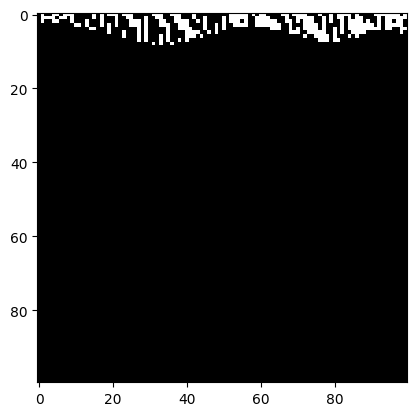

In [10]:
def plot_paper_criticiality_fits(plot_data_list):
    """
    Generates a 2x3 grid of log-log plots to replicate Figure 4 from the paper,
    using the data returned by compute_criticality_from_paper.

    Args:
        plot_data_list (list): A list of 6 dictionaries, one for each distribution.
    """
    if plot_data_list is None or len(plot_data_list) != 6:
        print("Invalid plot data provided. Cannot generate plots.")
        return

    titles = [
        'Avalanche size of state 0', 'Avalanche duration of state 0', 'Avalanche area of state 0',
        'Avalanche size of state 1', 'Avalanche duration of state 1', 'Avalanche area of state 1'
    ]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    for i, ax in enumerate(axes.ravel()):
        data = plot_data_list[i]

        if data['empirical_x'] is None:
            ax.set_title(f"{titles[i]}\n(No data)")
            continue

        # Plot the empirical data (blue line in the paper)
        ax.plot(data['empirical_x'], data['empirical_y'], 'b-', marker='o', markersize=4,
                label='Empirical Data (PDF)')

        # Plot the fitted line (dashed black line in the paper)
        if data['fit_x'] is not None:
            ax.plot(data['fit_x'], data['fit_y'], 'k--', linewidth=2,
                    label=f'Fit (α={data["alpha"]:.2f})')

        # --- Formatting ---
        ax.set_title(titles[i])
        ax.set_xlabel('x')
        ax.set_ylabel('P(x)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, which="both", ls="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()

a = best_individual.A
print(a.min(), a.max())
plt.imshow(a[:100,:100]<0, cmap="gray")